In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# screening the missing value
import missingno as msno

# Using for modeling
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,Ridge,Lasso,LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,plot_confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,OrdinalEncoder


from imblearn.over_sampling import SMOTE


from imblearn.pipeline import Pipeline

# Data Cleaning

In [31]:
df= pd.read_csv('./data/cheap_train_sample.csv')

In [32]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
wage              object
dtype: object

In [33]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,56,Private,346033,9th,5,Divorced,Adm-clerical,Not-in-family,Male,0,0,40,United-States,<=50K
1,28,Private,96226,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Male,0,0,45,United-States,<=50K
2,33,Private,251120,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,7688,0,50,United-States,>50K
3,26,Private,178140,Bachelors,13,Married-civ-spouse,Other-service,Husband,Male,0,0,45,United-States,>50K
4,40,Federal-gov,56795,Masters,14,Never-married,Exec-managerial,Not-in-family,Female,14084,0,55,United-States,>50K


In [34]:
# map values of y
df['wage'] = df['wage'].map({' <=50K':0,' >50K':1})

In [35]:
df.shape

(6513, 14)

In [36]:
df['education'].values.shape

(6513,)

In [37]:
# Convert countries with small proportion into 'Other'
name_2 = ['Other' if x in [' South', ' Jamaica',
       ' India', ' China', ' Puerto-Rico', ' England', ' Cuba', ' Italy',
       ' Poland', ' Japan', ' Haiti', ' Guatemala', ' Columbia', ' Taiwan',
       ' Iran', ' Peru', ' France', ' Vietnam', ' Cambodia', ' Nicaragua',
       ' Outlying-US(Guam-USVI-etc)', ' Portugal', ' Hong', ' Scotland',
       ' Ecuador', ' Yugoslavia', ' Greece', ' Hungary', ' Trinadad&Tobago',
       ' Ireland', ' Thailand', ' Laos', ' Honduras'] else x for x in df['native-country'].values]

df['native-country'] = name_2

df['native-country'].value_counts()

 United-States         5807
Other                   294
 Mexico                 150
 ?                      120
 Philippines             43
 El-Salvador             29
 Canada                  26
 Germany                 24
 Dominican-Republic      20
Name: native-country, dtype: int64

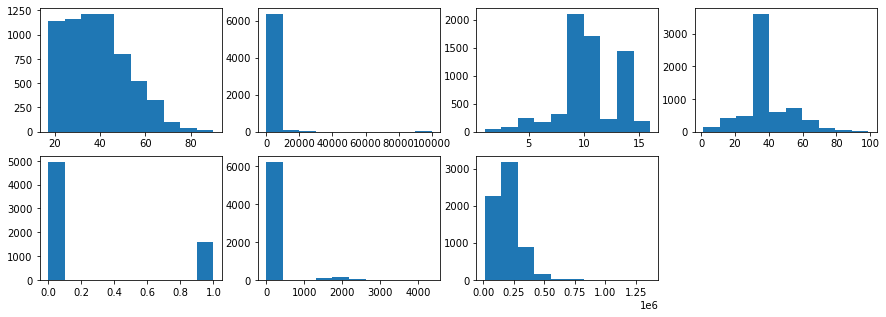

In [38]:
# Check outliers by hist plot

fig,ax = plt.subplots(2,4,figsize=(15,5))
ax[0][0].hist(df['age'])
ax[0][1].hist(df['capital-gain'])
ax[0][2].hist(df['education-num'])
ax[0][3].hist(df['hours-per-week'])
ax[1][0].hist(df['wage'])
ax[1][1].hist(df['capital-loss']) #drop
ax[1][2].hist(df['fnlwgt']) # drop
ax[1][3].remove()



In [39]:
# filter out outliers

df = df[df['hours-per-week'] <= 80]
df = df[df['capital-gain'] <= 30_000]
df = df[df['education-num'] > 3]


# drop columns
# remove fnlwgt,capital-loss  -- no meaning definition, most contain zero values 


df.drop(columns=['fnlwgt','capital-loss'],inplace=True)



In [40]:
df.shape

(6324, 12)

In [41]:
df.describe()

,age,education-num,capital-gain,hours-per-week,wage
count,6324.000000,6324.000000,6324.000000,6324.000000,6324.000000
mean,38.435484,10.194339,574.589817,40.090449,0.240196
std,13.685151,2.388496,2491.143771,11.702398,0.427236
min,17.000000,4.000000,0.000000,1.000000,0.000000
25%,27.000000,9.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,40.000000,0.000000
75%,48.000000,13.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,27828.000000,80.000000,1.000000


In [42]:
# dummy
df = pd.get_dummies(df,columns=['marital-status',
       'relationship', 'sex'],drop_first=True)
df = pd.get_dummies(df,columns=['workclass','occupation','native-country'])
df = pd.get_dummies(df,columns = ['education-num'],drop_first=True)

In [43]:
# Drop
df.drop(columns=['workclass_ ?','occupation_ ?','native-country_ ?'],inplace=True)
df.drop(columns=['education'],inplace=True)

In [44]:
df.head()

,age,capital-gain,hours-per-week,wage,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,...,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16
0,56,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28,0,45,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,33,7688,50,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,26,0,45,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,40,14084,55,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
# The imbalanced occurs in our data
df['wage'].value_counts(normalize=True).mul(100).round(2)

0    75.98
1    24.02
Name: wage, dtype: float64

In [46]:
# save data into csv file
df.to_csv('./data/cleand_df.csv')

# Plain Logistic Regression 

In [47]:
X = df.drop(columns='wage')
y= df['wage']

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [49]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4743, 57), (1581, 57), (4743,), (1581,))

In [50]:
# Scale
sc= StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [51]:
# Instantiate
logreg = LogisticRegression(penalty ='none')


# didn't scale
logreg.fit(X_train_sc,y_train)

LogisticRegression(penalty='none')

In [52]:
logreg.score(X_train_sc,y_train)

0.8490406915454354

In [53]:
logreg.score(X_test_sc,y_test)

0.8475648323845667

In [54]:
y_pred =logreg.predict(X_test_sc)

In [55]:
# imbalance
f1_score(y_test,y_pred)

0.6408345752608047

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1205
           1       0.73      0.57      0.64       376

    accuracy                           0.85      1581
   macro avg       0.80      0.75      0.77      1581
weighted avg       0.84      0.85      0.84      1581



In [57]:
logreg_coef = pd.DataFrame(logreg.coef_,columns=sc.get_feature_names_out()).T.sort_values(by=0,ascending=False)

<BarContainer object of 57 artists>

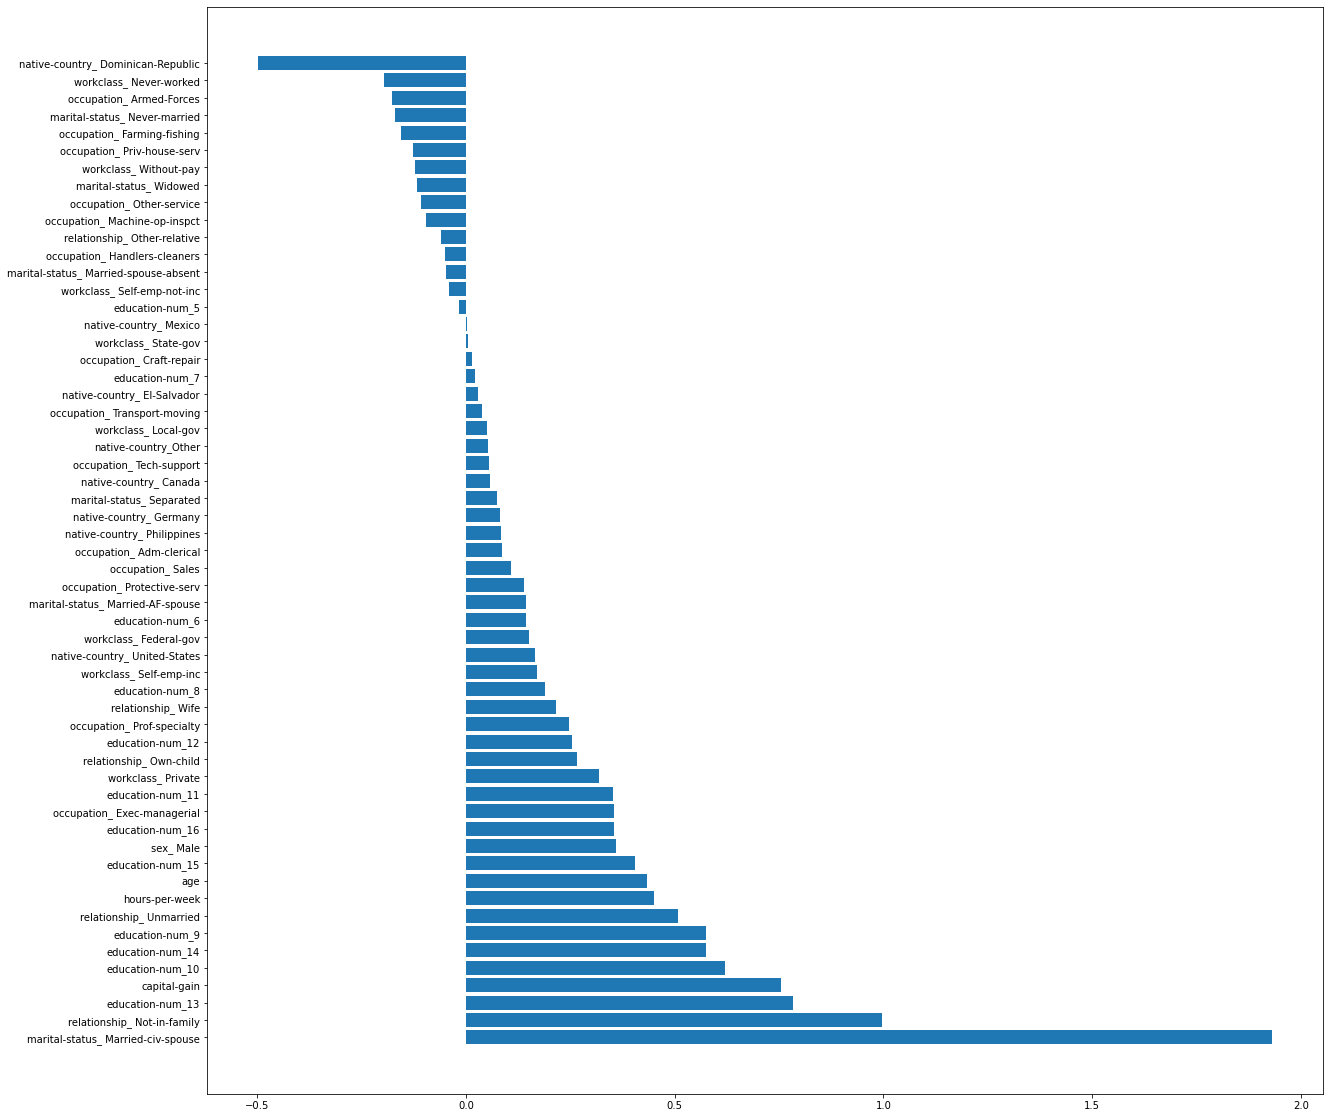

In [58]:
plt.figure(figsize=(20,20))
plt.barh(logreg_coef.index,logreg_coef[0])
